In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-04-13 12:47:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-04-13 12:47:49 (17.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [3]:
import tensorflow_datasets as tfds


In [4]:
#checking for food dataset
datasets_list = tfds.list_builders()
print("food101" in datasets_list) 


2023-04-13 12:48:03.809514: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


True


In [5]:

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /Users/nathanngaleu/tensorflow_datasets/food101/2.0.0.incompleteMLP16V/food101-train.tfrecord*...:  …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /Users/nathanngaleu/tensorflow_datasets/food101/2.0.0.incompleteMLP16V/food101-validation.tfrecord*.…

Dataset food101 downloaded and prepared to /Users/nathanngaleu/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1


In [6]:
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
class_names = ds_info.features["label"].names
class_names[:10]
     

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Taking a sample off
train_one_sample = train_data.take(1)

In [9]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 288, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 93
  Class name (str form): steak
        


2023-04-13 13:04:25.327648: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
#Cheecking image 
image

<tf.Tensor: shape=(512, 288, 3), dtype=uint8, numpy=
array([[[148, 103,  36],
        [147, 102,  35],
        [147, 102,  35],
        ...,
        [146, 111,  53],
        [146, 111,  53],
        [146, 111,  53]],

       [[147, 102,  35],
        [147, 102,  35],
        [148, 103,  36],
        ...,
        [145, 110,  52],
        [145, 110,  52],
        [145, 110,  52]],

       [[143,  98,  31],
        [144,  99,  32],
        [146, 101,  33],
        ...,
        [146, 111,  55],
        [146, 111,  55],
        [145, 110,  54]],

       ...,

       [[113,  69,  94],
        [113,  69,  94],
        [112,  68,  93],
        ...,
        [ 77,  53,  67],
        [ 76,  52,  66],
        [ 78,  54,  68]],

       [[115,  71,  96],
        [115,  71,  96],
        [114,  70,  95],
        ...,
        [ 79,  55,  69],
        [ 81,  54,  69],
        [ 82,  55,  70]],

       [[116,  72,  97],
        [117,  73,  98],
        [117,  73,  98],
        ...,
        [ 75,  51,  6

In [12]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

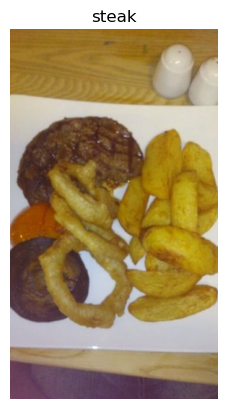

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [15]:
# Making a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label 
     

In [16]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")
     

Image before preprocessing:
 [[[148 103  36]
  [147 102  35]
  [147 102  35]
  ...
  [146 111  53]
  [146 111  53]
  [146 111  53]]

 [[147 102  35]
  [147 102  35]
  [148 103  36]
  ...
  [145 110  52]
  [145 110  52]
  [145 110  52]]]...,
Shape: (512, 288, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[147.30612  102.30612   35.30612 ]
  [147.27551  102.27551   35.27551 ]
  [148.61224  103.61224   36.612244]
  ...
  [145.61224  110.61225   52.612247]
  [145.35715  110.35714   52.357143]
  [145.35715  110.35714   52.357143]]

 [[142.34694   97.34694   30.34694 ]
  [144.85715   99.85714   32.42857 ]
  [146.       101.        33.      ]
  ...
  [144.14285  109.14285   53.142857]
  [144.14285  109.14285   53.142857]
  [143.2857   108.285706  52.28571 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


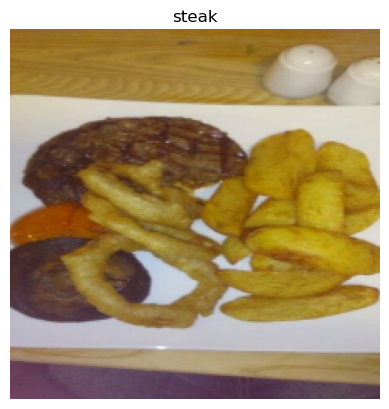

In [17]:
#ploting image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Mapping preprocessing function to training data 
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data 
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Mapping
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [20]:
#callbacks

# TensorBoard callback 
from helper_functions import create_tensorboard_callback

#  ModelCheckpoint callback 
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0) 
     

In [21]:
# Mix precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 
     

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Building the Model

In [23]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#  base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

# Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compiling
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [25]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [27]:
for layer in model.layers[1].layers[:20]: 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
     

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <